In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [37]:
train = pd.read_csv(r"/kaggle/input/playground-series-s4e7/train.csv")
test = pd.read_csv(r'/kaggle/input/playground-series-s4e7/test.csv')

In [13]:
print("---BASIC INFO ABOUT OUR DATASET---")
print(train.info())
print("---MATHEMATICAL DESCRIPTION---")
print(train.describe())
print("---CHECK FOR NULL VALUES---")
print(train.isnull().sum())  # Check for missing values


---BASIC INFO ABOUT OUR DATASET---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                int64  
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           int64  
 7   Vehicle_Damage        int64  
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(9)
memory usage: 1.0 GB
None
---MATHEMATICAL DESCRIPTION---
                 id        Gender           Age  Driving_License  \
count  1.150480e+07  1.150480e+07  1.150480e+07     1.150480e+07   
mean   5.752398e+06  5.413510e-01  3.838356e+01     9.980220e-01   
std    3.321149e+06  4.982872e-01  1.499346e+01     4.443120e-02   
mi

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


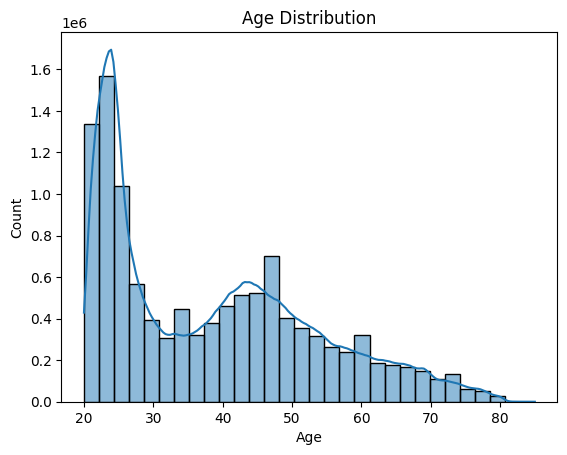

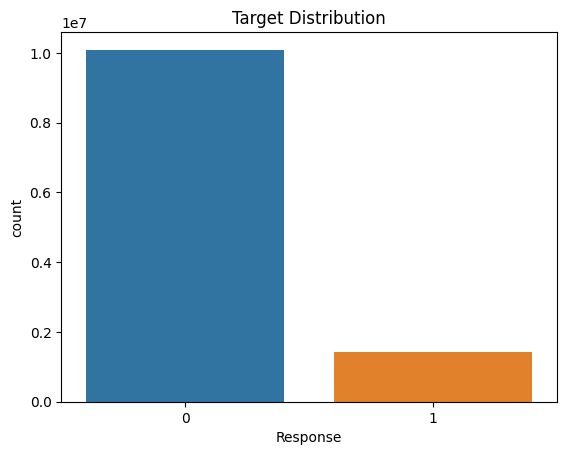

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age distribution
sns.histplot(train['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# Response distribution (target)
sns.countplot(data=train, x='Response')
plt.title('Target Distribution')
plt.show()


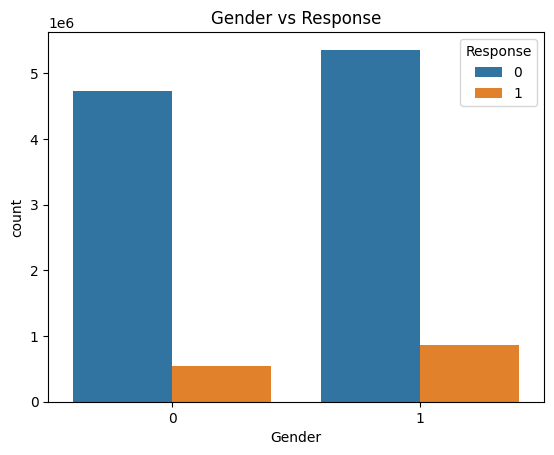

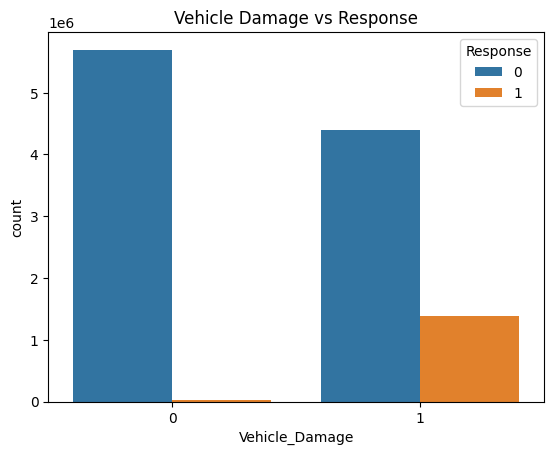

In [15]:
# Gender vs Response
sns.countplot(data=train, x='Gender', hue='Response')
plt.title('Gender vs Response')
plt.show()

# Vehicle Damage vs Response
sns.countplot(data=train, x='Vehicle_Damage', hue='Response')
plt.title('Vehicle Damage vs Response')
plt.show()

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Gender'] = le.fit_transform(train['Gender'])
train['Vehicle_Damage'] = le.fit_transform(train['Vehicle_Damage'])

test['Gender'] = le.transform(test['Gender'])
test['Vehicle_Damage'] = le.transform(test['Vehicle_Damage'])

# Map vehicle age to integers
vehicle_age_map = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
train['Vehicle_Age'] = train['Vehicle_Age'].map(vehicle_age_map)
test['Vehicle_Age'] = test['Vehicle_Age'].map(vehicle_age_map)


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


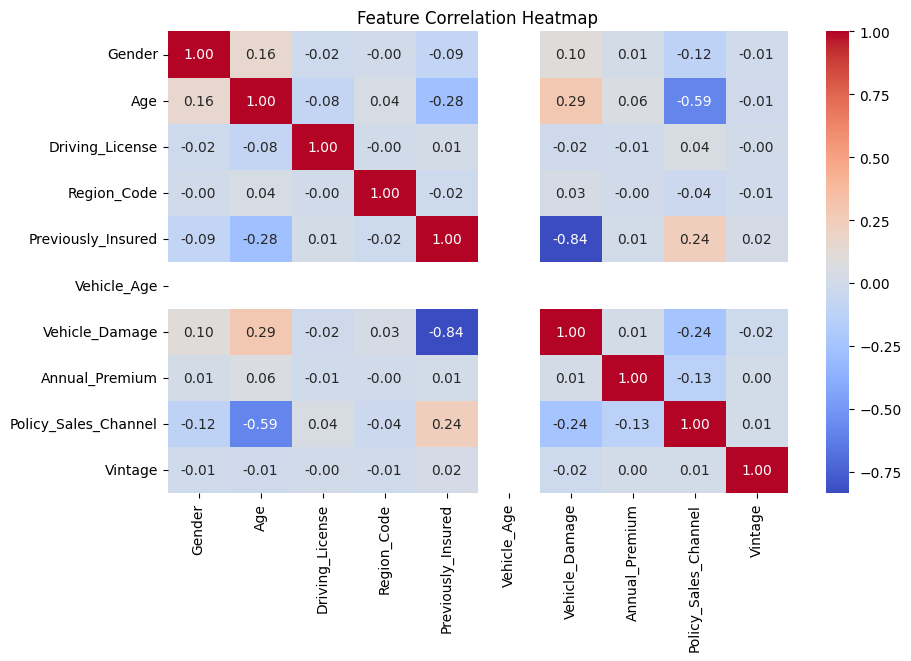

In [18]:
import numpy as np

# Drop ID and target for correlation check
corr_matrix = train.drop(['id', 'Response'], axis=1).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


[LightGBM] [Info] Number of positive: 1132047, number of negative: 8071791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.197945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122997 -> initscore=-1.964348
[LightGBM] [Info] Start training from score -1.964348


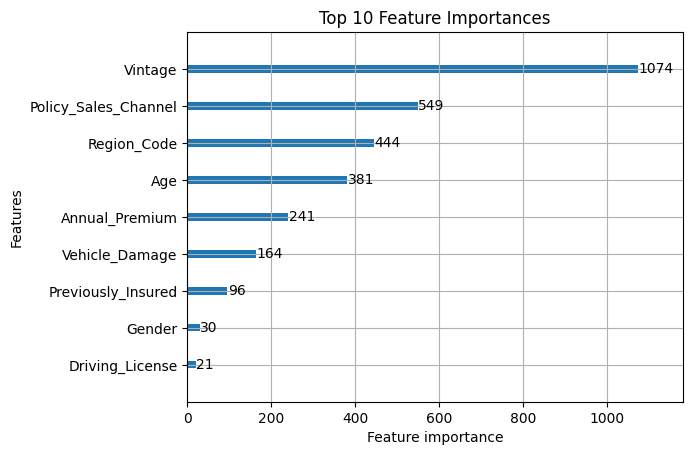

In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X = train.drop(['id', 'Response'], axis=1)
y = train['Response']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Plot importance
lgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


In [20]:
X = X.drop(['Gender', 'Driving_License'], axis=1)
test = test.drop(['Gender', 'Driving_License'], axis=1)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [22]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

model = lgb.LGBMClassifier(
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Evaluate
auc = roc_auc_score(y_val, y_pred)
print("Validation ROC AUC Score:", auc)


[LightGBM] [Info] Number of positive: 1132047, number of negative: 8071791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122997 -> initscore=-1.964348
[LightGBM] [Info] Start training from score -1.964348
Validation ROC AUC Score: 0.8712512718599358


# GOOD

In [6]:
print(train.shape)
train.head()

(11504798, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [7]:
#Check for missing values
train.isnull().sum()


id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [8]:
#check for class balance
train['Response'].value_counts(normalize=True)


Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Gender'] = le.fit_transform(train['Gender'])
test['Gender'] = le.transform(test['Gender'])

train['Vehicle_Age'] = train['Vehicle_Age'].map({'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0})
test['Vehicle_Age'] = test['Vehicle_Age'].map({'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0})

train['Vehicle_Damage'] = le.fit_transform(train['Vehicle_Damage'])
test['Vehicle_Damage'] = le.transform(test['Vehicle_Damage'])


In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = train.drop(['id', 'Response'], axis=1)
y = train['Response']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
print("Validation ROC AUC Score:", roc_auc_score(y_val, y_pred))


[LightGBM] [Info] Number of positive: 1132047, number of negative: 8071791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122997 -> initscore=-1.964348
[LightGBM] [Info] Start training from score -1.964348
Validation ROC AUC Score: 0.8757815472195281


[LightGBM] [Info] Number of positive: 1415059, number of negative: 10089739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.289466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 11504798, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122997 -> initscore=-1.964348
[LightGBM] [Info] Start training from score -1.964348


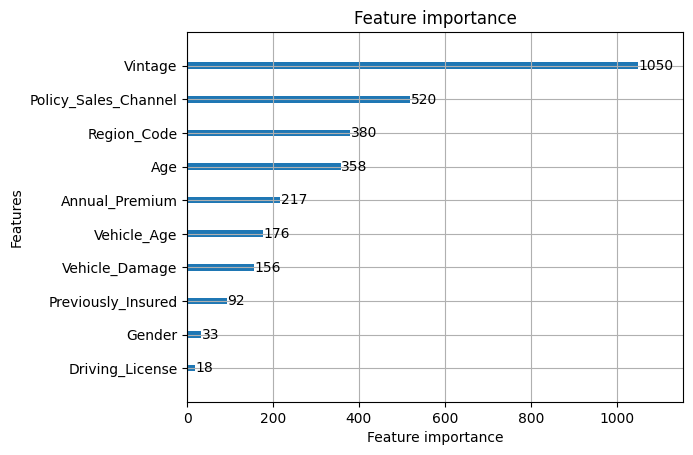

In [11]:
import lightgbm as lgb
import matplotlib.pyplot as plt

model = lgb.LGBMClassifier(random_state=42)
model.fit(X, y)

# Plot feature importance
lgb.plot_importance(model, max_num_features=10)
plt.show()


# Huy


In [38]:
df = pd.read_csv(r"/kaggle/input/playground-series-s4e7/train.csv")

In [39]:
numerical_df = df.select_dtypes(include=['number'])
# numerical_features = numerical_df.columns.tolist()

categorical_df = df.select_dtypes(include=['object'])
# categorical_df = categorical_df.columns.to_list()

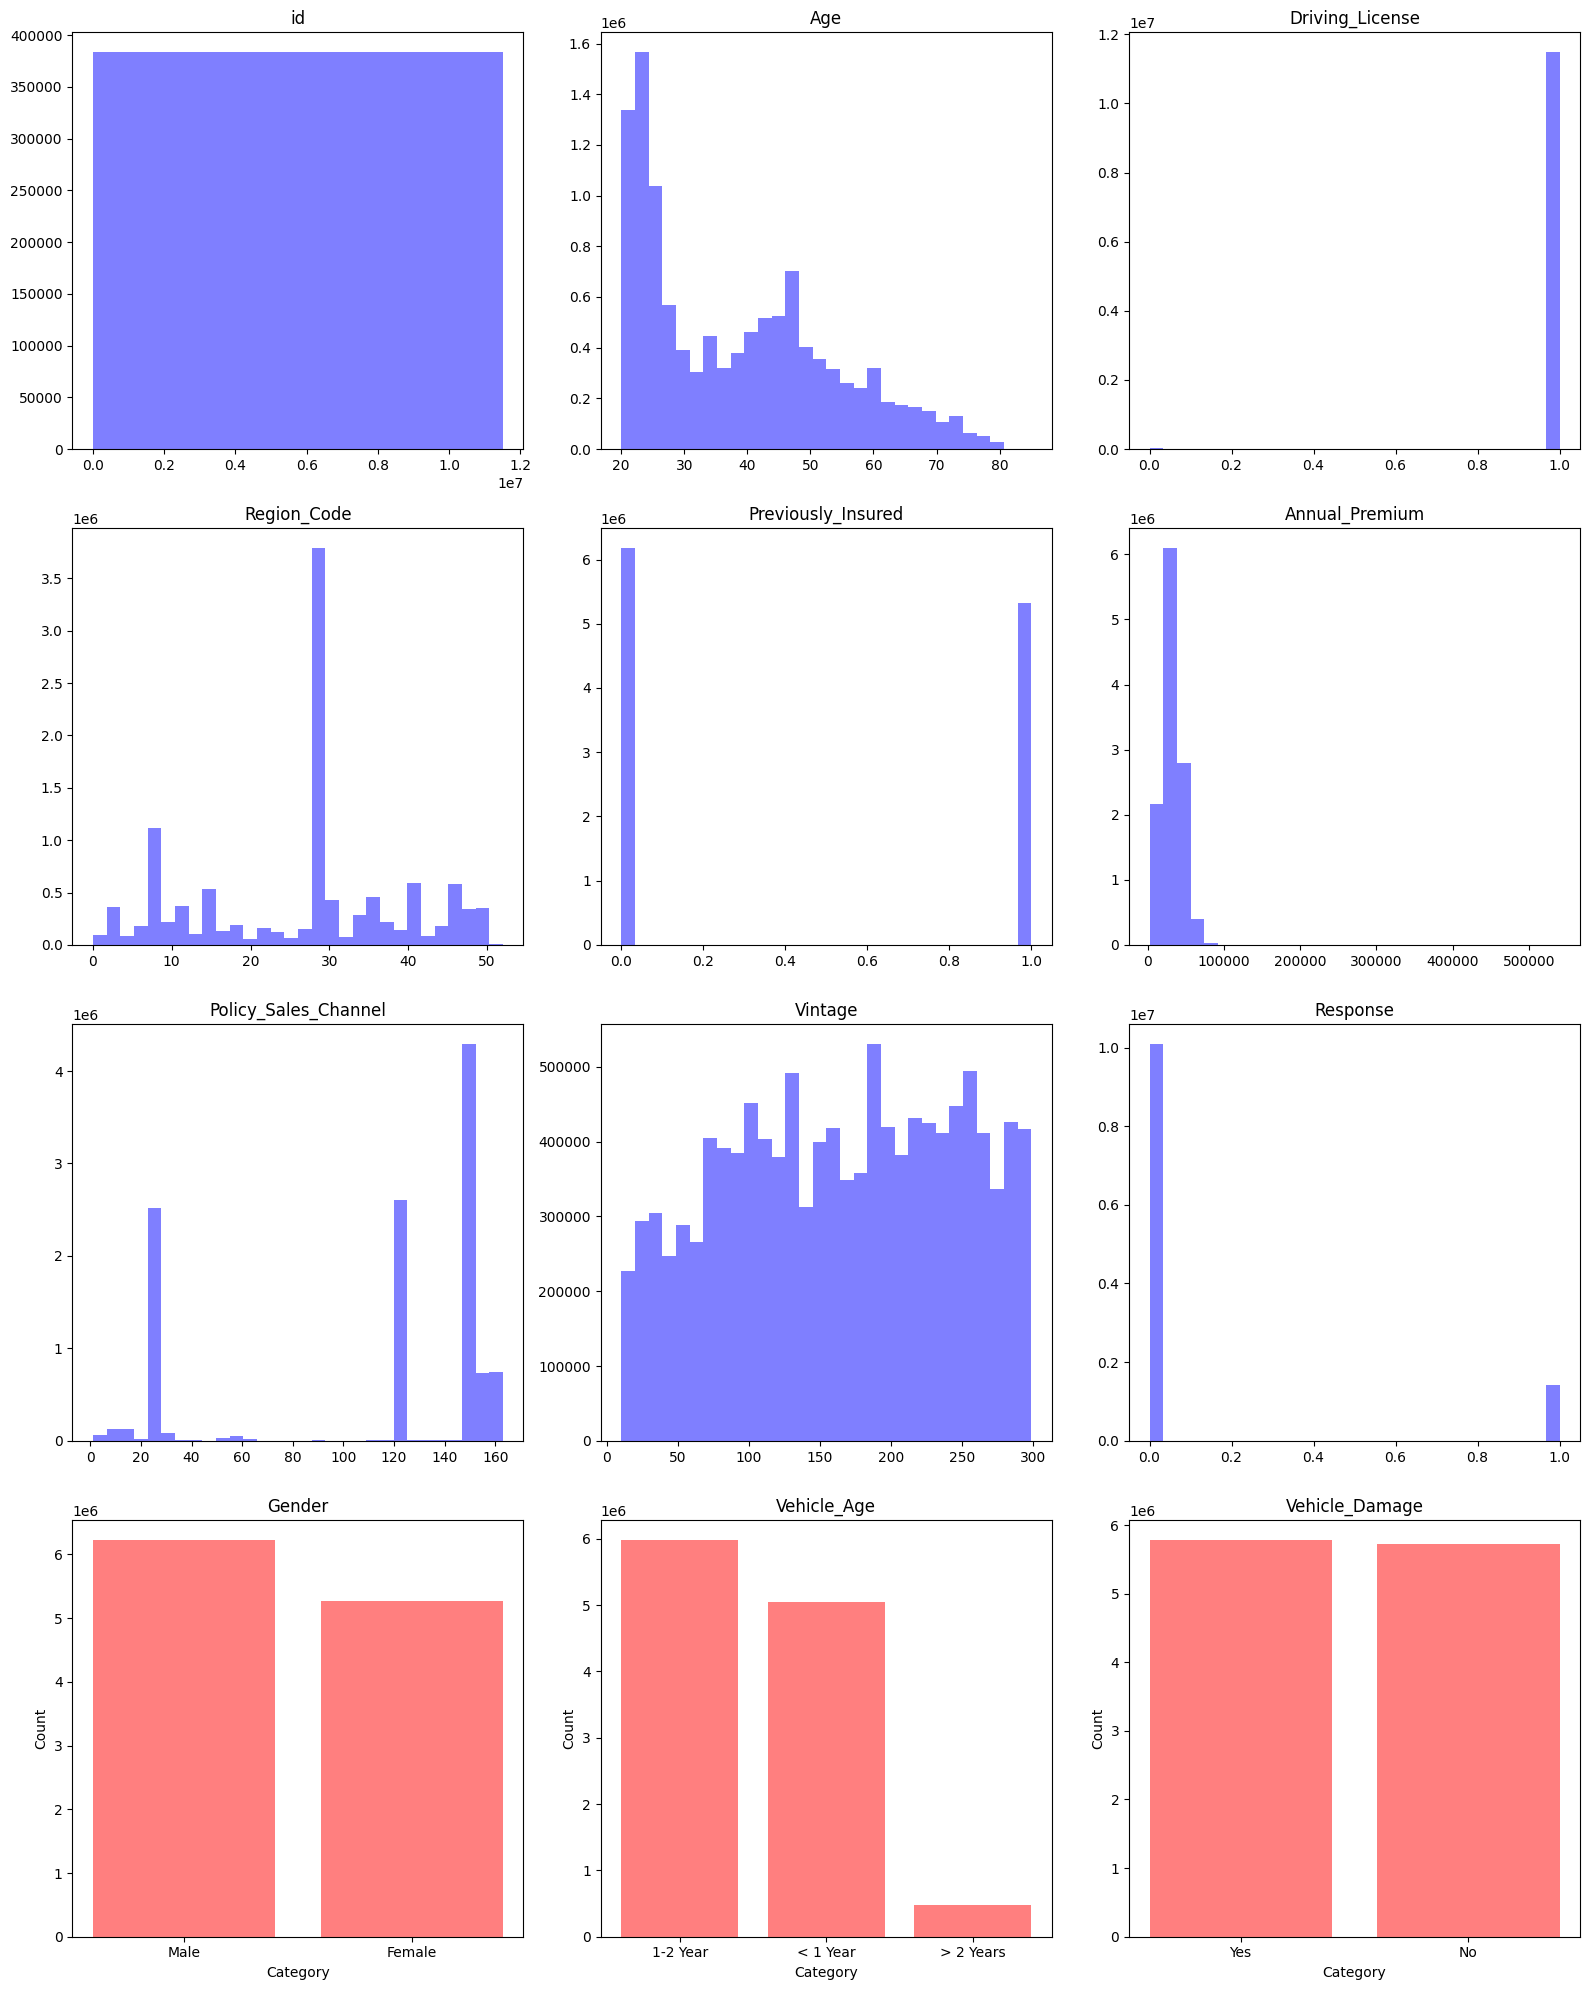

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 3, figsize=(16, 20))
axs = axs.flatten()

index = 0

# Loop through each numerical column and plot a histogram
for num_ft in numerical_df.columns:
    ax = axs[index]
    ax.hist(numerical_df[num_ft], bins=30, alpha=0.5, color='blue')
    ax.set_title(num_ft)
    index += 1

# Loop through each categorical column and plot a bar chart of value counts
for cat_ft in categorical_df.columns:
    ax = axs[index]
    # Get the frequency counts for each category
    counts = categorical_df[cat_ft].value_counts()
    # Create a bar chart using the category names as labels
    ax.bar(counts.index.astype(str), counts.values, alpha=0.5, color='red')
    ax.set_title(cat_ft)
    ax.set_xlabel("Category")
    ax.set_ylabel("Count")
    index+=1

plt.tight_layout()
plt.show()

In [41]:
from sklearn.preprocessing import LabelEncoder

# Binary features
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Male = 1, Female = 0
df['Vehicle_Damage'] = le.fit_transform(df['Vehicle_Damage'])  # Yes = 1, No = 0

# 3-category feature
df['Vehicle_Age'] = df['Vehicle_Age'].map({
    '< 1 Year': 0,
    '1-2 Year': 1,
    '> 2 Years': 2
})


In [43]:
# Drop unimportant features
df = df.drop(['Gender', 'Driving_License'], axis=1)

# Split into features and target
X = df.drop(['id', 'Response'], axis=1)
y = df['Response']


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [45]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

model = lgb.LGBMClassifier(
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print("Validation ROC AUC Score:", auc)


[LightGBM] [Info] Number of positive: 1132047, number of negative: 8071791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122997 -> initscore=-1.964348
[LightGBM] [Info] Start training from score -1.964348
Validation ROC AUC Score: 0.8726111061296409
